## Setup

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf

import os
import math

# Main slim library
from tensorflow.contrib import slim

Populating the interactive namespace from numpy and matplotlib


## Display Bird Images

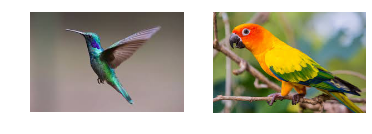

In [2]:
bird0 = mpimg.imread(os.path.join('..', 'Data', 'birds', 'bird_0.jpg'))
bird1 = mpimg.imread(os.path.join('..', 'Data', 'birds', 'bird_1.jpg'))
plt.figure()
plt.subplot(121)
plt.imshow(bird0)
plt.axis('off')

plt.subplot(122)
plt.imshow(bird1)
plt.axis('off')
plt.show()

## Building Graph and Predicting

(2, 1000)
INFO:tensorflow:Restoring parameters from .\vgg_16.ckpt


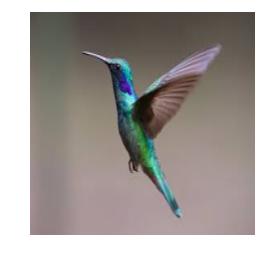

Probability 99.95% => [hummingbird]
Probability 0.04% => [jacamar]
Probability 0.01% => [bee eater]
Probability 0.00% => [black stork, Ciconia nigra]
Probability 0.00% => [red-breasted merganser, Mergus serrator]


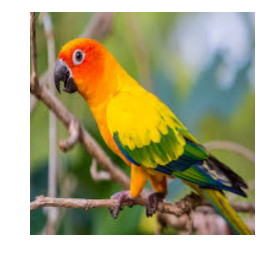

Probability 99.31% => [lorikeet]
Probability 0.46% => [macaw]
Probability 0.05% => [hummingbird]
Probability 0.04% => [bee eater]
Probability 0.04% => [jacamar]


In [3]:
# from slim library
import vgg_preprocessing
import imagenet
import vgg

# global
image_size  = vgg.vgg_16.default_image_size
initialized = False

def resize_squeeze(img, img_size):
    image = tf.image.resize_images(img, [img_size, img_size])
    image = tf.squeeze(image)
    return image

def build_graph():
    
    image_placeholder = tf.placeholder(tf.float32, shape=[None, None, None, 3])
    processed_images = vgg_preprocessing.preprocess_image(image_placeholder, image_size, image_size, is_training=False)
    with slim.arg_scope(vgg.vgg_arg_scope()):
        logits, _ = vgg.vgg_16(processed_images, num_classes=1000, is_training=False, reuse=initialized)
    probabilities = tf.nn.softmax(logits)
    return probabilities, image_placeholder

def init_variables():
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join('.', 'vgg_16.ckpt'),
        slim.get_model_variables('vgg_16'))
    return init_fn

def predict(images, probabilities, image_placeholder):
    np_probabilities = sess.run(probabilities, feed_dict={image_placeholder: images})
    return np_probabilities


def showImages(np_images_raw):
    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(batch_size): 
        image = np_images_raw[i, :, :, :]
        np_probability = np_probabilities[i, :]
        sorted_inds = [j[0] for j in sorted(enumerate(-np_probability), key=lambda x:x[1])]

        plt.figure()
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plt.show()

        for k in range(5):
                index = sorted_inds[k]
                # Shift the index of a class name by one. 
                print('Probability %0.2f%% => [%s]' % (np_probability[index] * 100, names[index+1]))
    
    
    with tf.Session() as sess:
        init_fn(sess)
        np_probabilities, np_images_raw = sess.run([probabilities, images_raw])

  

tf.reset_default_graph()
                    
with tf.Graph().as_default():
    
    # for display
    raw_image1 = resize_squeeze(bird0, image_size)
    raw_image2 = resize_squeeze(bird1, image_size)

    # for vgg input
    processed_image1 = vgg_preprocessing.preprocess_image(bird0, image_size, image_size, is_training=False)
    processed_image2 = vgg_preprocessing.preprocess_image(bird1, image_size, image_size, is_training=False)
    
    # Network inputs for the two birds
    batch_size = 2
    processed_images = tf.stack([processed_image1, processed_image2])
    images_raw = tf.stack([raw_image1, raw_image2])     
    
    vgg16_output(processed_images, images_raw, batch_size)

(4, 1000)
INFO:tensorflow:Restoring parameters from .\vgg_16.ckpt


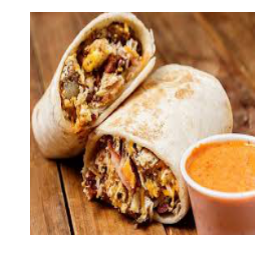

Probability 98.85% => [burrito]
Probability 0.33% => [guacamole]
Probability 0.22% => [potpie]
Probability 0.11% => [plate]
Probability 0.11% => [French loaf]


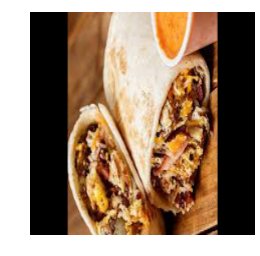

Probability 79.21% => [burrito]
Probability 2.57% => [butternut squash]
Probability 2.39% => [guacamole]
Probability 1.85% => [French loaf]
Probability 1.61% => [pizza, pizza pie]


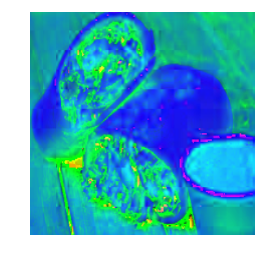

Probability 43.10% => [beaker]
Probability 25.14% => [Petri dish]
Probability 13.18% => [bubble]
Probability 6.58% => [measuring cup]
Probability 3.50% => [oscilloscope, scope, cathode-ray oscilloscope, CRO]


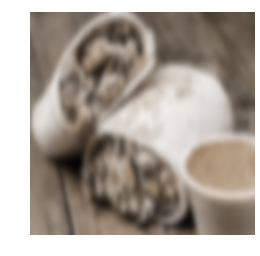

Probability 57.92% => [rock python, rock snake, Python sebae]
Probability 3.34% => [sidewinder, horned rattlesnake, Crotalus cerastes]
Probability 2.74% => [eggnog]
Probability 2.34% => [chambered nautilus, pearly nautilus, nautilus]
Probability 1.91% => [boa constrictor, Constrictor constrictor]


In [4]:
from skimage import transform
from skimage import color
from skimage import filters

tf.reset_default_graph()

with tf.Graph().as_default():
    
    # for display
    orig_burrito          = mpimg.imread(os.path.join('..', 'Data', 'burrito.jpg'))
    orig_burritoRS        = resize_squeeze(orig_burrito, image_size)
    g_tform_burrito       = transform.rotate(orig_burrito, angle=90)*255
    g_tform_burritoRS     = resize_squeeze(g_tform_burrito, image_size)
    color_tform_burrito   = color.convert_colorspace(orig_burrito, 'RGB', 'HSV')*255
    color_tform_burritoRS = resize_squeeze(color_tform_burrito, image_size)
    filtered_burrito      = filters.gaussian(orig_burrito, sigma=3, multichannel=False)*255
    filtered_burritoRS    = resize_squeeze(filtered_burrito, image_size)
    
    # for vgg input
    pimage_orig        = vgg_preprocessing.preprocess_image(orig_burrito, image_size, image_size, is_training=False)
    pimage_g_tform     = vgg_preprocessing.preprocess_image(g_tform_burrito, image_size, image_size, is_training=False)
    pimage_color_tform = vgg_preprocessing.preprocess_image(color_tform_burrito, image_size, image_size, is_training=False)
    pimage_filtered    = vgg_preprocessing.preprocess_image(filtered_burrito, image_size, image_size, is_training=False)
    
    # Network inputs for the two birds
    batch_size          = 4
    pimages             = tf.stack([pimage_orig, pimage_g_tform, pimage_color_tform, pimage_filtered])
    raw_images_burrito  = tf.stack([orig_burritoRS, g_tform_burritoRS, color_tform_burritoRS, filtered_burritoRS])    
    
    vgg16_output(pimages, raw_images_burrito, batch_size)